# Autoencoders

Autoencoder (автокодер, автоэнкодер, AE) — нейронная сеть, которая копирует входные данные на выход. По архитектуре похож на персептрон. Автоэнкодеры сжимают входные данные для представления их в latent-space (скрытое пространство), а затем восстанавливают из этого представления выходные данные. Цель — получить на выходном слое от/клик, наиболее близкий к входному.

В данном ноутбуке мы рассмотрим реализацию разных автоэнкодеров, а именно:
<br>
1. **Vanilla Autoencoder**
<br>
2. **Variational Autoencoder**
<br>
3. **Conditional Variational Autoencoder**
<br>

Способы их применения будем рассматривать на датасетах:
<br>
1. **Labelled Faces in the Wild (LFW)**. Этот датасет содержит картинки лиц людей и их атрибуты
<br>
2. **MNIST**. Этот датасет содержит картинки рукописных цифр от 0 до 9.

## 1. Vanilla Autoencoder (AE)

### 1.1. Подготовка данных


Выполняем импорт необходимых библиотек

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torchvision
import matplotlib.pyplot as plt
import matplotlib.style as style
from IPython.display import clear_output

style.use("fivethirtyeight")

%matplotlib inline

Реализуем функцию для загрузки датасета с картинками лиц:

In [3]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [4]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):
    
    import urllib.request

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        urllib.request.urlretrieve("http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz", "tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        urllib.request.urlretrieve("http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt",
                                   attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv(attrs_name, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img, [dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

Загрузим два наших датасета: сами картинки с лицами людей и их атрибуты. Атрибуты включают в себя следующую информацию: есть на человеке очки, улыбается ли человек и т. п.

In [4]:
data, attrs = fetch_dataset()

Разобьем наши датасеты картинок и атрибутов на train и val. Выведим несколько картинок, чтобы посмотреть, как они выглядят. А также приведем картинки к тензорам pytorch, чтобы можно было прогнать через сеть:

In [5]:
data, attrs = fetch_dataset()
batch_size = 32
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size)

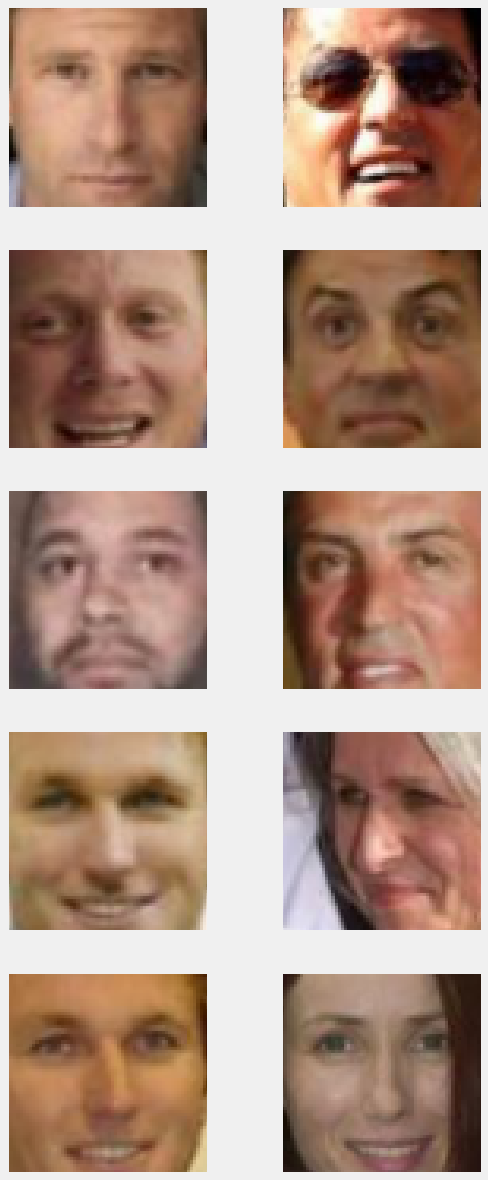

In [76]:
fig = plt.figure(figsize=(8, 20))

for i, (tr, val) in enumerate(zip(train_photos[:5], val_photos[:5])):
    ax = fig.add_subplot(5, 2, 2*i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(tr)
    ax.grid(False)
    
    ax = fig.add_subplot(5, 2, 2*i+2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(val)
    ax.grid(False)
    
plt.show()

### 1.2. Архитектура модели

<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

Реализуем обычный автоэнкодер. Архитектура нашего автоэнкодер будет состоять из энкодера и декодера. Сами энкодер и декодер сформированы следующим образом:
<br>
**nn.Linear > nn.BatchNorm1d > nn.ReLU**

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        #encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_code),
            nn.BatchNorm1d(dim_code),
            nn.ReLU(),
        )
        
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500, 64*64*3),
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        reconstruction = torch.sigmoid(reconstruction)

        return reconstruction, latent_code

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 64, 64, 3)

        return generated

### 1.3. Обучение

Напишем цикл обучения нашего autoencoder. В процессе будем сохранять значения функций потерь для вывода последующей аналитики по обучению и валидации. Обучение будем выполнять на GPU, а как функцию потерь будем использовать MSE.

In [51]:
#training parameters
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # a device used in training and testing
n_epochs = 50 # a number of training epochs
dim_code = 128 # a size of a latent space

#defining a model, an optimizer and a loss function
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss

#lists for saving losses
train_losses_per_epoch = []
val_losses_per_epoch = []

#training loop
for epoch in tqdm(range(n_epochs)):
    model.train() # set the mode to train
    avg_train_loss = 0 # initiate a train loss
    
    for X_batch in train_loader:
        X_batch = X_batch.float().to(device) # data to the device
        optimizer.zero_grad() # set gradients parameters to zero
        reconstructed, latent_code = model(X_batch) # forward-pass
        reconstructed = reconstructed.view(-1, 64, 64, 3) # reshape the output tensor to a proper output format
        loss = loss_fn(reconstructed, X_batch) # calculate an average training loss for the current epoch
        loss.backward() # backward-pass
        optimizer.step() # update weights
        avg_train_loss += loss.detach().cpu().item() # add a loss and transfer it to a cpu
        
    train_losses_per_epoch.append(avg_train_loss / len(train_loader)) # save an average training loss for the current epoch

    model.eval() # set the mode to eval
    avg_eval_loss = 0 # initiate an eval loss

    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.float().to(device) # data to the device
            reconstructed, latent_code = model(X_batch)  # forward-pass
            reconstructed = reconstructed.view(-1, 64, 64, 3) # reshape the output tensor to a proper output format
            loss = loss_fn(reconstructed, X_batch) # calculate an average evaluation loss for the current epoch 
            avg_eval_loss += loss.detach().cpu().item() # add a loss and transfer it to a cpu
            
        val_losses_per_epoch.append(avg_eval_loss / len(val_loader)) # save an average evaluation loss
                                                                     # for the current epoch

  0%|          | 0/50 [00:00<?, ?it/s]

Выведем полученные значения функций потерь в разрезе эпох:

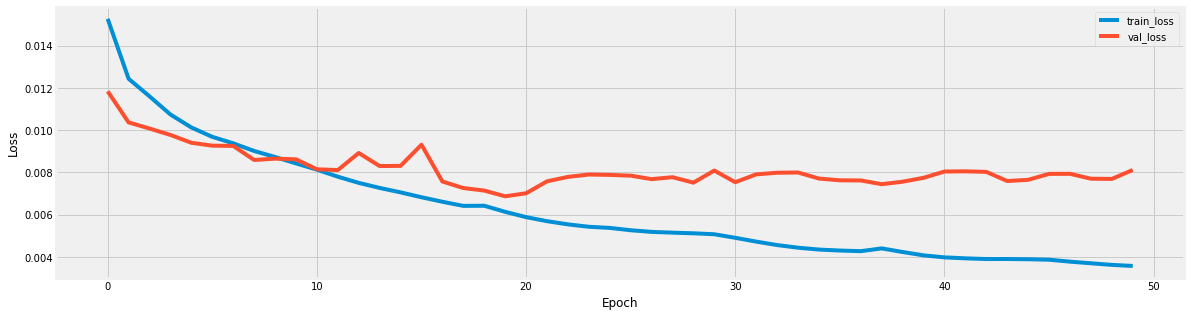

In [50]:
plt.figure(figsize=(18, 5))
plt.plot(train_losses_per_epoch, label="train_loss")
plt.plot(val_losses_per_epoch, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Значения функций потерь получились небольшие как во время тренировки, так и во время валидации, хотя на валидации модель справилась чуть хуже, чем во время тренировки.

Давайте посмотрим, как наш тренированный autoencoder кодирует и восстанавливает картинки:

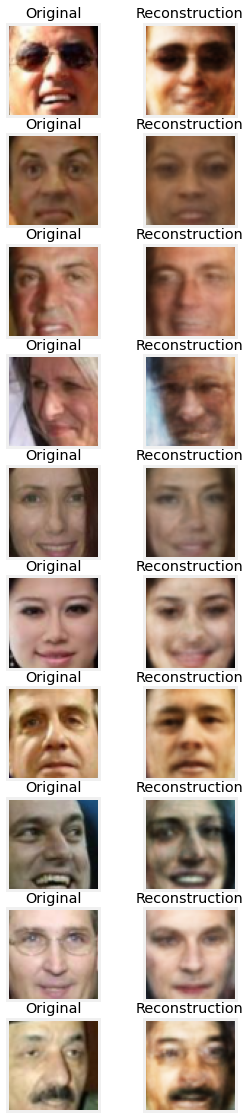

In [52]:
model.eval() # set the mode to eval

# lists for original images and reconstructions
reconstructions = []
originals = []

with torch.no_grad():   
    for batch in val_loader:
        batch = batch.float().to(device) # data to the device
        reconstructed, latent_code = model(batch) # forward-pass
        reconstructed = reconstructed.view(-1, 64, 64, 3) # reshape the output tensor to a proper output format 
        result = reconstructed.detach().cpu().numpy() # transfer a reconstruction to the cpu and convert it to numpy array 
        ground_truth = batch.detach().cpu().numpy() # transfer an original image to the cpu and convert it to numpy array 
        
        # save images to lists
        for i in range(len(batch)):
            reconstructions.append(result[i])
            originals.append(ground_truth[i])

# visualize results
fig, ax = plt.subplots(10, 2, figsize=(4, 20))

for i, (gt, res) in enumerate(zip(originals[:10], reconstructions[:10])):
    ax[i, 0].imshow(gt)
    ax[i, 0].grid(False)
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_title("Original")
    ax[i, 1].imshow(res)
    ax[i, 1].grid(False)
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title("Reconstruction")

plt.show()

Автоэнкодер в большинстве случаев восстановил картинки достаточно близко к оригиналам, хотя в некоторых случаях заметны сильные искажения.

### 1.4. Sampling

Автоэнкодер неплохо восстанавливает картинки на основании латентных векторов оригиналов.
Посмотрим, как автоэнкодер генерирует новые картинки на основании векторов из нормального распределения размерности латентного пространства с небольшими корректировками.

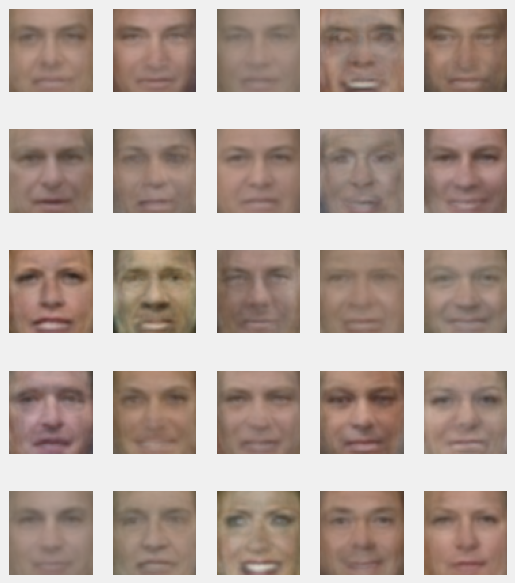

In [63]:
# generate 25 random vectors of the latent shape
z = np.abs(np.random.randn(25, dim_code)) - 0.5
output = model.sample(torch.FloatTensor(z).to(device))

fig = plt.figure(figsize=(8, 10))

for i, pic in enumerate(output[:25]):
    pic = pic.detach().cpu().numpy()
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(pic)
    ax.grid(False)
    
plt.show()

Автоэнкодер сгенерировал разные картинки лиц. На них можно различить различные черты лиц, пола, эмоций.

### 1.5. Добавление атрибутов на картинку

Автоэнкодер может не только восстанавливать картинки из латентных векторов, но и добавлять атрибуты (например, улыбки).

Для этого необходимо:
<br>
1. Нужно выделить "вектор улыбки": для этого нужно из выборки картинок найти несколько (~15) людей с улыбками и столько же без. Найти людей с улыбками можно с помощью датасета, который содержит аттрибуты к картинким. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)
<br>
2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder). Сделать тоже самое для людей без улыбок.
<br>
3. Вычислить, собственно, вектор улыбки - посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором людей без улыбки.
<br>
4. А теперь добавим улыбку человеку: добавим полученный в пункте 3 вектор к латентному вектору человека без улыбки и прогоним полученный вектор через decoder. Получим того же человека, но уже с улыбкой.
<br>

Получим индексы картинок с улыбками и без на основании данных датасета с атрибутами:

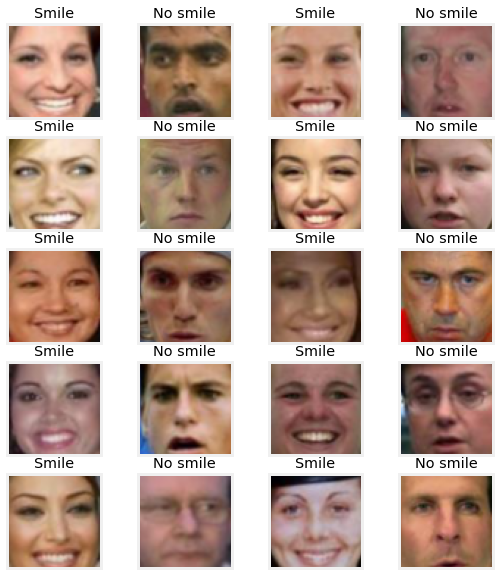

In [57]:
smile_ids = train_attrs['Smiling'].sort_values(ascending=False).head(25).index.values # extract smile images indices
smile_data = data[smile_ids] # extract images with smiles
no_smile_ids = train_attrs['Smiling'].sort_values(ascending=True).head(25).index.values # extract images indices
                                                                                        # without smiles
no_smile_data = data[no_smile_ids] # extract images without smiles

# visualize extracted data
fig = plt.figure(figsize=(8, 10))

for i, (sm, nosm) in enumerate(zip(smile_data[:10], no_smile_data[:10])):
    ax = fig.add_subplot(5, 4, 2*i+1)
    ax.imshow(sm)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Smile")
    ax = fig.add_subplot(5, 4, 2*i+2)
    ax.imshow(nosm)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("No smile")

plt.show()

Используем энкодер нашей модели для получения латентных векторов наших картинок с улыбками и без. Вычтем латентный вектор улыбок из латентного вектора улыбок и посмотрим на результат:

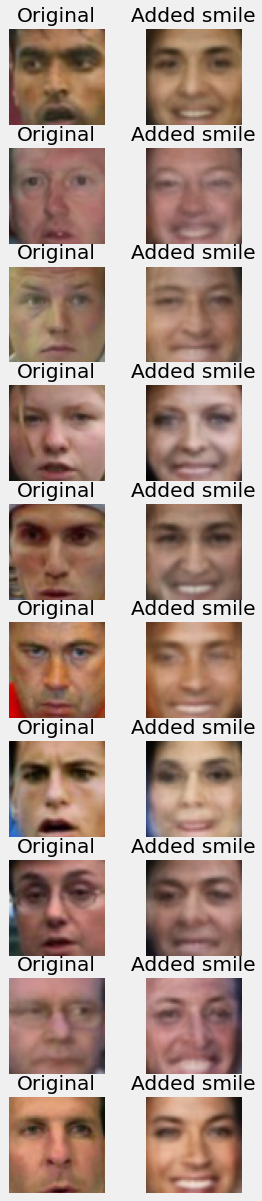

In [65]:
#data loaders
smile_loader = torch.utils.data.DataLoader(smile_data, 25)
no_smile_loader = torch.utils.data.DataLoader(no_smile_data, 25)

init
smile_latent = 0
no_smile_latent = 0

model.eval()

# extract the smile latent vector
with torch.no_grad():
    for X_batch in smile_loader:
        X_batch = X_batch.float().to(device)
        latent = model.encoder(X_batch)
        smile_latent += torch.mean(latent, axis=0) 

# extract the no smile latent vector
with torch.no_grad():
    for X_batch in no_smile_loader:
        X_batch = X_batch.float().to(device)
        latent = model.encoder(X_batch)
        no_smile_latent += torch.mean(latent, axis=0)

actual_latent = smile_latent - no_smile_latent

no_smile_loader = torch.utils.data.DataLoader(no_smile_data, 1)

smile_pic = []
no_smile_pic = []

#add smiles to images
with torch.no_grad():
    for i, X_batch in enumerate(no_smile_loader):
        X_batch = X_batch.float().to(device)
        no_smile_latent = model.encoder(X_batch)
        reconstruction = torch.sigmoid(model.decoder(no_smile_latent + actual_latent))
        reconstruction = reconstruction.view(64, 64, 3).detach().cpu().numpy()
        original = X_batch.view(64, 64, 3).detach().cpu().numpy()
        
        for i in range(len(X_batch)):
            smile_pic.append(reconstruction)
            no_smile_pic.append(original)

# visualize results
fig, ax = plt.subplots(10, 2, figsize=(4, 20))

for i, (nosm, sm) in enumerate(zip(no_smile_pic[:10], smile_pic[:10])):
    ax[i, 0].imshow(nosm)
    ax[i, 0].grid(False)
    ax[i, 0].set_title("Original")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 1].imshow(sm)
    ax[i, 1].grid(False)
    ax[i, 1].set_title("Added smile")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    
plt.show()

В результате автоэнкодер добавил улыбки на картинки людей без улыбок. Аналогично можно добавлять очки, закрывать или открывать глаза и т.п.

## 2. Variational Autoencoder (VAE)

Построим обычный **Variational Autoencoder (VAE)**, который будет состоять из сверточных слоев. Отличие **VAE** от обычного **AE** заключается в так называемом **reparametrization trick**: преобразование, позволяющее перейти от случайной величины, имеющей стандартное нормальное распределение (со средним 0 и дисперсией 1), к произвольной нормальной случайной величине. Такой трюк позволяет генерировать латентный вектор из произвольного нормального распределения.
Обучать **VAE** будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9.

In [4]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=torchvision.transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 2.1.Архитектура модели

Реализуем VAE. VAE также будет состоять из энкодера и декодера. Архитектура энкодера будет состоять из **Conv2d > BatchNorm2d > ReLU**, а декодера из **TransposeConv2d > BatchNorm2d > ReLU**. Также реализуем отдельное преобразование выхода из энкодера в латентный вектор и наоборот.

In [16]:
class VAE(nn.Module):
    def __init__(self, channels, latent_shape, from_lat_kernel):
        super().__init__()
        self.channels = channels
        self.latent_shape = latent_shape
        self.from_lat_kernel = from_lat_kernel
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=self.channels, out_channels=16, kernel_size=2, padding=0, stride=2), # Shape / 2
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=2), # Shape / 2
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=2), # Shape / 2
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        # transfer to latent space
        self.to_latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*latent_shape*latent_shape, dim_code),
            
        )
        
        # transfer from latent space
        self.from_latent = nn.Sequential(
            nn.Linear(dim_code, 64*self.latent_shape*self.latent_shape),
            nn.Unflatten(1, [64, self.latent_shape, self.latent_shape]),
            
        )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.from_lat_kernel,
                               padding=1, stride=2), # shape * 2
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, padding=1, stride=2), # shape * 2
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=self.channels, kernel_size=4, padding=1, stride=2), # shape * 2         
        )


    def encode(self, x):
        x = self.encoder(x)
        mu = self.to_latent(x)
        logsigma = self.to_latent(x)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            
            return sample

        else:
            return mu
    
    def decode(self, z):
        z = self.from_latent(z)
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [17]:
def KL_divergence(mu, logsigma):
    # part of the loss, which measures how one probability distribution is different from a second, 
    # reference probability distribution 
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    # part of the loss, which measures quality of reconstruction (like MSE in simple AE)
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Аналогично реализуем цикл обучения для VAE на датасете MNIST:

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # a device used in training and testing
n_epochs = 50 # number of epochs
dim_code = 256 # shape of the latent space

# a model, an optimizer & a loss function
model = VAE(channels=1, latent_shape=4, from_lat_kernel=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = loss_vae

# lists to save losses
train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in tqdm(range(n_epochs)):
    model.train() # set the model to the train mode
    avg_train_loss = 0 # initiate a train loss
    
    for X_batch, _ in train_loader:
        X_batch = X_batch.float().to(device) # transfer data to the device
        optimizer.zero_grad() # set gradients parameters to zero
        mu, logsigma, reconstructed = model(X_batch) # forward-pass
        reconstructed = reconstructed.view(-1, 1, 28, 28) # reshape the output tensor to a proper output format
        loss = loss_fn(X_batch, mu, logsigma, reconstructed) # calculate the train loss
        loss.backward() # backward-pass
        optimizer.step() # update weights
        avg_train_loss += loss.detach().cpu().item() # add loss and transfer it to the cpu

    train_losses_per_epoch.append(avg_train_loss / len(train_loader)) # save the calculated train loss

    model.eval() # set the model to the evaluation mode
    avg_val_loss = 0 # initiate an evaluation loss
    
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.float().to(device) # transfer data to the device
            mu, logsigma, reconstructed = model(X_batch) # forward-pass
            reconstructed = reconstructed.view(-1, 1, 28, 28) # reshape the output tensor to a proper output format
            loss = loss_fn(X_batch, mu, logsigma, reconstructed) # calculate the evaluation loss
            avg_val_loss += loss.detach().cpu().item() # add loss and transfer it to the cpu

    val_losses_per_epoch.append(avg_val_loss / len(val_loader)) # save the calculated evaluation loss

  0%|          | 0/50 [00:00<?, ?it/s]

Выведем графики лосса на обучении и валидации:

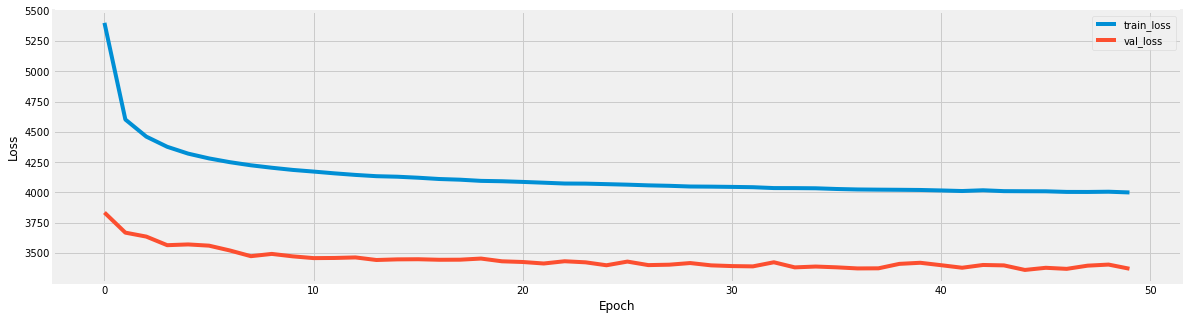

In [19]:
plt.figure(figsize=(18, 5))
plt.plot(train_losses_per_epoch, label="train_loss")
plt.plot(val_losses_per_epoch, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

По графикам видно, что наш VAE лучше справился на валидации, чем на обучении. Посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

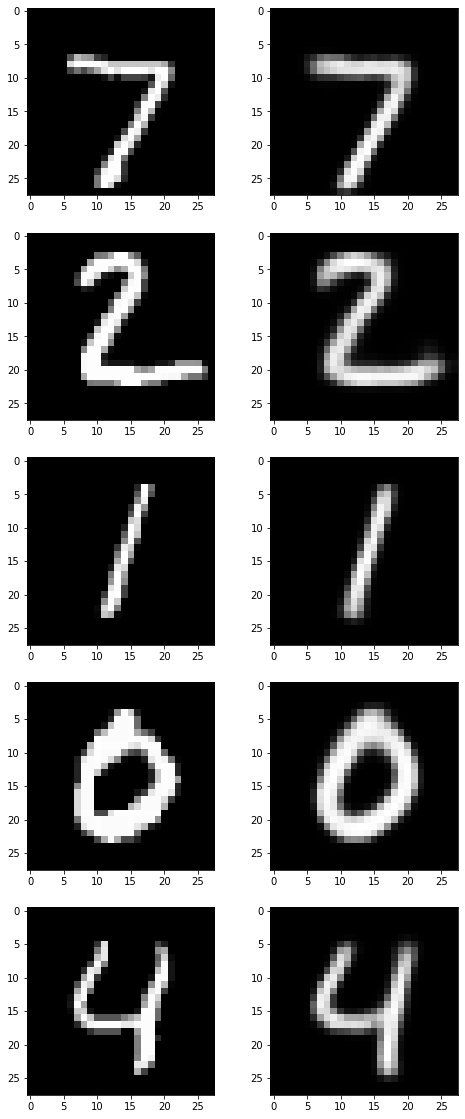

In [411]:
model.eval()

with torch.no_grad():
    for batch, _ in val_loader:
        batch = batch.float().to(device)
        mu, logsigma, reconstructed = model(batch)
        reconstructed = reconstructed.view(-1, 28, 28)
        result = reconstructed.detach().cpu().numpy()
        ground_truth = batch.view(-1, 28, 28).detach().cpu().numpy()

fig = plt.figure(figsize=(8, 20))

for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    ax = fig.add_subplot(5, 2, 2*i+1)
    ax.imshow(gt, cmap="gray")
    ax = fig.add_subplot(5, 2, 2*i+2)
    ax.imshow(res, cmap="gray")

VAE очень хорошо восстанавливает картинки цифр.
Попробуем проделать для VAE то же, что и с обычным AE - передать декодеру из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

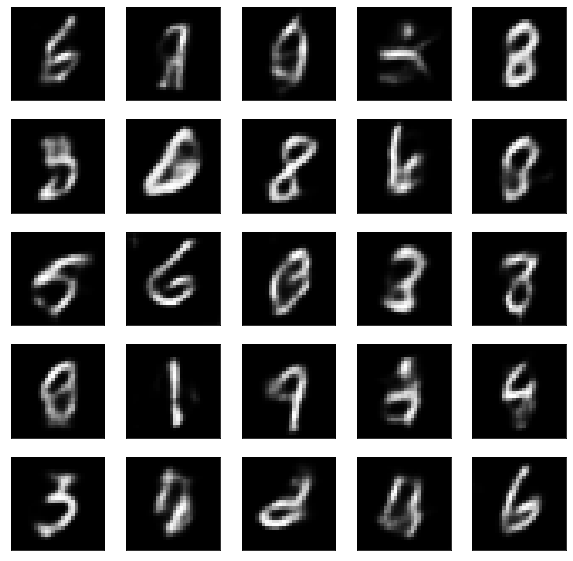

In [409]:
z = np.array([np.random.normal(0, 1.3, dim_code) for i in range(25)])
output = model.decode(torch.FloatTensor(z).to(device))

fig = plt.figure(figsize=(10, 10))

for i, generated in enumerate(output[:25]):
    generated = generated.view(28, 28).detach().cpu().numpy()
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(generated, cmap="gray")
    ax.grid(False)

plt.show()

Цифры восстановленные из случайных векторов выглядят не так четко, как реконструкции, но различимы.

### 2.2. Latent Representation

Посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Для этого нам надо изобразить латентные векторы картинок точками в двумерном просторанстве. 
Это позволит оценить, насколько плотно распределены латентные векторы картинок цифр в пространстве. 
Покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет.
Для этого:
<br>
1. Получим латентные представления картинок тестового датасета
<br>
2. С помощью `TSNE` (есть в `sklearn`) "сожмем" эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
<br>
3. Визуализируем полученные двумерные представления с помощью `matplotlib.scatter`, покрасив разными цветами точки, соответствующие картинкам разных цифр.

In [594]:
from sklearn.manifold import TSNE
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
latent_reps = {}

# initiate dicts to store coordinates for each class of a dataset
for i in sorted(test_dataset.targets):
    if i.item() not in latent_reps:
        latent_reps[str(i.item())] = {"x":[], "y":[]}

# extract latent vectors and 
for batch, labels in val_loader:
    batch = batch.float().to(device)
    latent = model.to_latent(model.encoder(batch))
    latent = latent.detach().cpu().numpy()
    latent_rep = TSNE(n_components=2).fit_transform(latent)
    
    # save the coordinates for the each class
    for coord, label in zip(latent_rep, labels):
        latent_reps[str(label.item())]["x"].append(coord[0])
        latent_reps[str(label.item())]["y"].append(coord[1])      

Выведем распределение наших латентных векторов:

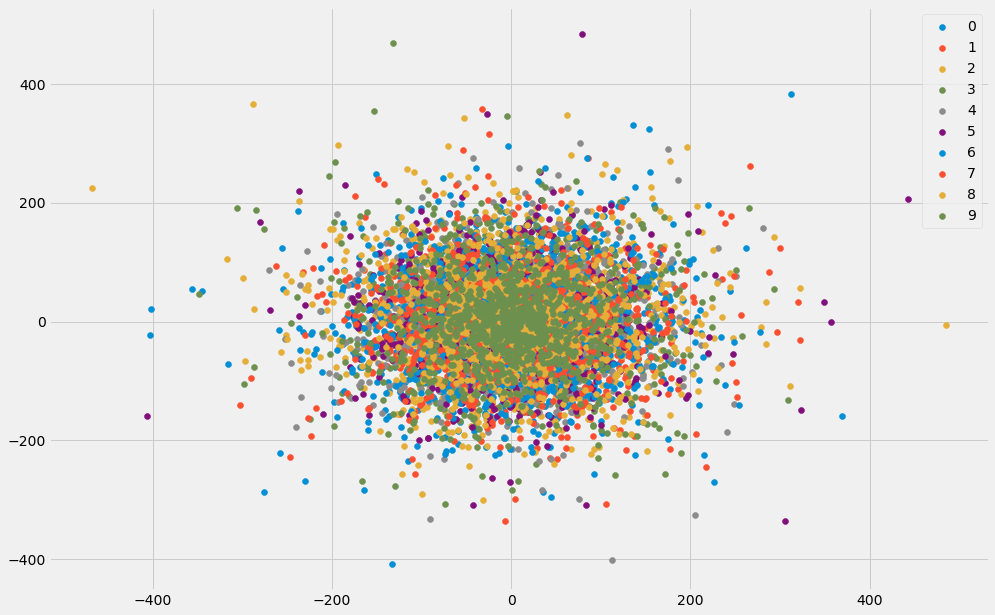

In [599]:
fig, ax = plt.subplots(figsize=(15, 10))

for key, value in latent_reps.items():
    ax.scatter(value["x"], value["y"], label=key)

plt.legend()

## 3. Conditional VAE (CVAE)


Мы уже научились обучать обычный AE и VAE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
<br>
Допустим, что мы обучили VAE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
<br>
И вот нам понадобилось сгенерировать цифру 7, и мы подставляем разные варианты шума, но семерка никак не генерируется.
Для того, чтобы генерировать определенные цифры, к нашему AE необходимо добавить функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
<br>
Conditional VAE — так называется вид автоэнкодера, который предоставляет такую возможность. Т.е. по заданному условию CVAE будет генерировать желаемые цифры.

### 3.1. Архитектура

На картинке ниже представлена архитектура Conditional VAE.
<br>
По сути, единственное отличие от обычного - это то, что мы вместе с картинку в первом слое энкодера и декодера передаем еще информацию о классе картинки. 
<br>
То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.
Построим CVAE и напишем функцию для кодирования классов картинки (one-hot encoding).

In [5]:
# one-hot encoding
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)

    for i, label in enumerate(labels):
        targets[i, label.long()] = 1
        
    return targets.to(device)

class CVAE(nn.Module):
    def __init__(self, feature_size, class_size, dim_code, from_lat_kernel):
        super().__init__()
        self.feature_size = feature_size
        self.class_size = class_size
        self.dim_code = dim_code
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, padding=0, stride=2), #28 > 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=2), #14 > 7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=2), #7 > 4
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        # transfer to latent space
        self.to_latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*4*4, dim_code),
            
        )
        
        # transfer from latent space
        self.from_latent = nn.Sequential(
            nn.Linear(dim_code + class_size, 64*4*4),
            nn.Unflatten(1, [64, 4, 4]),
            
        )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=2), #4 > 7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, padding=1, stride=2), #7 > 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, padding=1, stride=2), #14 > 28            
        )
        

    def encode(self, x, class_num):
        x = self.encoder(x)
        mu = self.to_latent(x)
        logsigma = self.to_latent(x)

        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)
            
            return sample
        
        else:
            return mu
    
    def decode(self, z, class_num):
        z = torch.cat([z, class_num], 1)
        z = self.from_latent(z)
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        
        return mu, logsigma, reconstruction

### 3.2. Обучение

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # a device used in training and testing
n_epochs = 50 # number of epochs
dim_code = 256 # shape of the latent-space
class_size = 10 # num of clusses for one-hot encoding
feature_size = 28*28*1 # shape of images

# a model, an optimizer & a loss function
model = CVAE(feature_size, class_size, dim_code).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = loss_vae

# lists to save losses
train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in tqdm(range(n_epochs)):
    model.train() # set the model to the train mode
    avg_train_loss = 0 # initiate loss training loss variable
    
    for X_batch, Y_batch in train_loader:
        # transfer data to the device
        X_batch = X_batch.float().to(device)
        Y_batch = Y_batch.float().to(device)
        Y_batch = one_hot(Y_batch, 10) # create one-hot encoding
        optimizer.zero_grad() # set gradients parameters to zero
        mu, logsigma, reconstructed = model(X_batch, Y_batch) # forward-pass
        reconstructed = reconstructed.view(-1, 1, 28, 28) # reshape the tensor to a proper output format
        loss = loss_fn(X_batch, mu, logsigma, reconstructed) # calculate the training loss
        loss.backward() # backward-pass
        optimizer.step() # update weights
        avg_train_loss += loss.detach().cpu().item() # add loss and transfer it to the cpu

    train_losses_per_epoch.append(avg_train_loss / len(train_loader)) # save the training loss

    model.eval() # set the model to the evaluation mode
    avg_val_loss = 0 # initiate loss evaluation loss variable
    
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            # transfer data to the device
            X_batch = X_batch.float().to(device)
            Y_batch = Y_batch.float().to(device)
            Y_batch = one_hot(Y_batch, class_size) # create one-hot encoding
            mu, logsigma, reconstructed = model(X_batch, Y_batch) # forward-pass
            reconstructed = reconstructed.view(-1, 1, 28, 28) # reshape the tensor to a proper output format
            loss = loss_fn(X_batch, mu, logsigma, reconstructed) # calculate the evaluation loss
            avg_val_loss += loss.detach().cpu().item() # add the loss and transfer it to the cpu

    val_losses_per_epoch.append(avg_val_loss / len(val_loader)) # save the evaluation loss

  0%|          | 0/50 [00:00<?, ?it/s]

Посмотрим как CVAE реконструирует картинки:

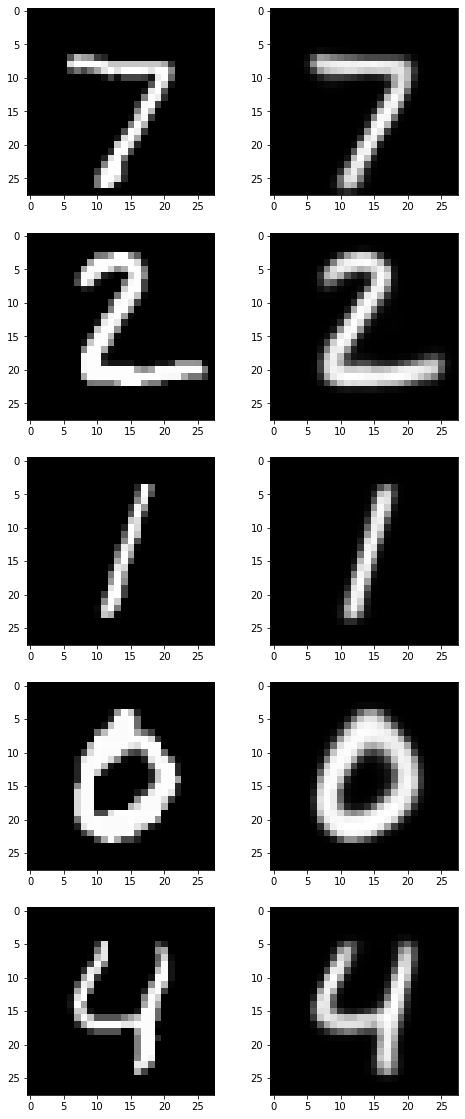

In [78]:
model.eval()

with torch.no_grad():
    for batch, label in val_loader:
        label = one_hot(label, class_size)
        batch = batch.float().to(device)
        mu, logsigma, reconstructed = model(batch, label)
        reconstructed = reconstructed.view(-1, 28, 28)
        result = reconstructed.detach().cpu().numpy()
        ground_truth = batch.view(-1, 28, 28).detach().cpu().numpy()

fig = plt.figure(figsize=(8, 20))

for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    ax = fig.add_subplot(5, 2, 2*i+1)
    ax.imshow(gt, cmap="gray")
    ax = fig.add_subplot(5, 2, 2*i+2)
    ax.imshow(res, cmap="gray")

### 3.3. Sampling


Попробуем сэмплировать из CVAE. Попросим CVAE восстановить картинки разных классов из одного и того же вектора.

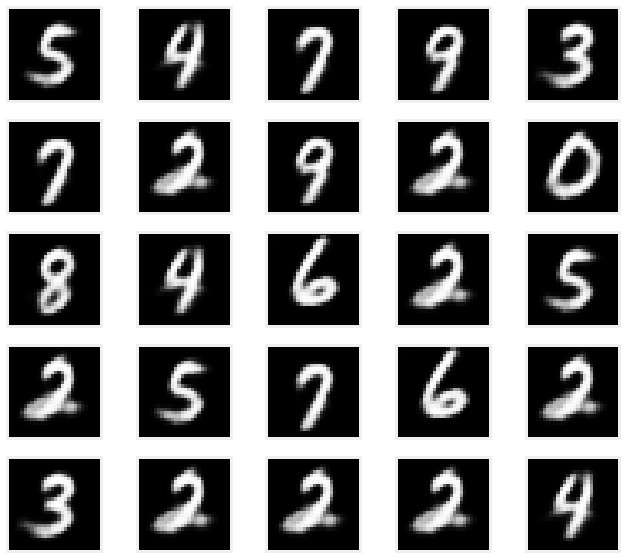

In [17]:
z = np.random.normal(0, 1.3, dim_code)
z = np.array([z for i in range(25)])
labels = one_hot(torch.FloatTensor(np.array([np.random.randint(0, 10) for i in range(0, 25)])), class_size)
output = model.decode(torch.FloatTensor(z).to(device), labels)

fig = plt.figure(figsize=(10, 10))

for i, generated in enumerate(output[:25]):
    generated = generated.view(28, 28).detach().cpu().numpy()
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(generated, cmap="gray")
    ax.grid(False)

plt.show()

### 3.4. Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинки в CVAE.

In [96]:
from sklearn.manifold import TSNE
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
latent_reps = {}

for i in sorted(test_dataset.targets):
    if i.item() not in latent_reps:
        latent_reps[str(i.item())] = {"x":[], "y":[]}

for batch, labels in val_loader:
    batch = batch.float().to(device)
    latent = model.to_latent(model.encoder(batch))
    latent = latent.detach().cpu().numpy()
    latent_rep = TSNE(n_components=2).fit_transform(latent)

    for coord, label in zip(latent_rep, labels):
        latent_reps[str(label.item())]["x"].append(coord[0])
        latent_reps[str(label.item())]["y"].append(coord[1])

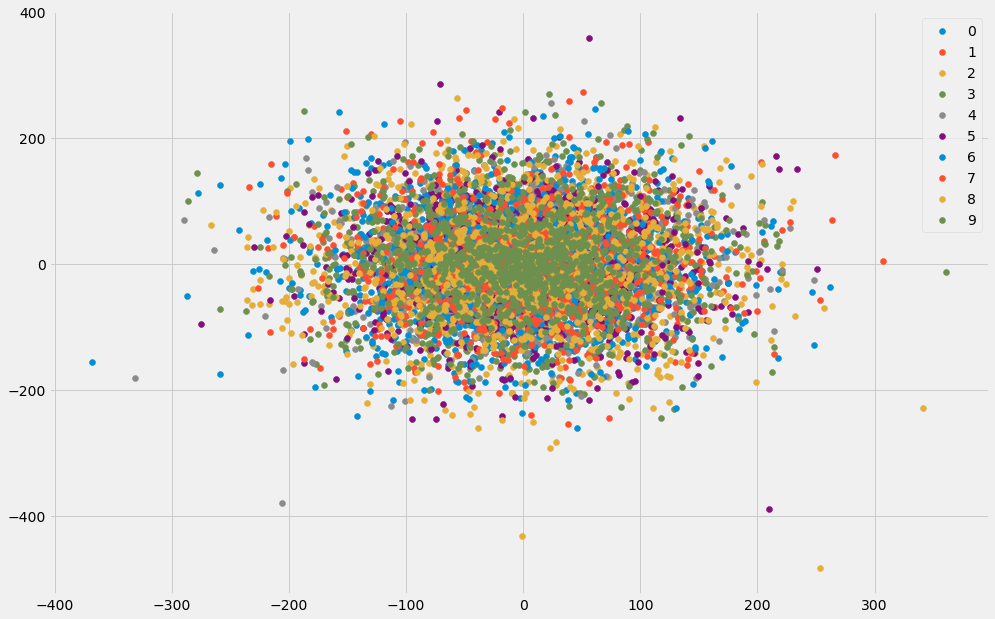

In [97]:
import matplotlib.style as style
style.use("fivethirtyeight")

fig, ax = plt.subplots(figsize=(15, 10))

for key, value in latent_reps.items():
    ax.scatter(value["x"], value["y"], label=key)

plt.legend()

Латентное простаранство CVAE и VAE выглядят примерно одинаковыми.

# 4. Denoising

У автоэнкодеров, кроме сжатия и генерации картинок, есть другие практические применения.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: входная картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция VAE останется той же, а на вход автоэнкодеру будет подаваться зашумленная картинка.

Для этого нужно взять датасет лиц и сделать копию этого датасета с шумом. 

Шум можно добавить следующим образом:

In [9]:
data, attrs = fetch_dataset()
batch_size = 32
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)

In [10]:
noise_factor = 0.5

train_noisy = train_photos.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_photos.shape)
val_noisy = val_photos.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_photos.shape)

In [11]:
train_loader = torch.utils.data.DataLoader(train_noisy, batch_size)
val_loader = torch.utils.data.DataLoader(val_noisy, batch_size)

Обучим VAE на зашумленных картинках:

In [34]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # a device used in training and testing
n_epochs = 100 # number of epochs
dim_code = 128 # shape of the latent-space

# a model, an optimizer & a loss function
model = VAE(channels=3, latent_shape=8, from_lat_kernel=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = loss_vae

# lists to save losses
train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in tqdm(range(n_epochs)):
    model.train() # set the model to the train mode
    avg_train_loss = 0 # initiate loss training loss variable
    
    for X_batch in train_loader:
        # transfer data to the device
        X_batch = X_batch.float().to(device)
        optimizer.zero_grad() # set gradients parameters to zero
        mu, logsigma, reconstructed = model(X_batch.view(-1, 3, 64, 64)) # forward-pass
        reconstructed = reconstructed.view(-1, 64, 64, 3) # reshape the tensor to a proper output format
        loss = loss_fn(X_batch, mu, logsigma, reconstructed) # calculate the training loss
        loss.backward() # backward-pass
        optimizer.step() # update weights
        avg_train_loss += loss.detach().cpu().item() # add loss and transfer it to the cpu
        
    train_losses_per_epoch.append(avg_train_loss / len(train_loader)) # save the training loss


    model.eval() # set the model to the evaluation mode
    avg_val_loss = 0 # initiate loss evaluation loss variable
    
    with torch.no_grad():
        for X_batch in val_loader:
            # transfer data to the device
            X_batch = X_batch.float().to(device)
            mu, logsigma, reconstructed = model(X_batch.view(-1, 3, 64, 64)) # forward-pass
            reconstructed = reconstructed.view(-1, 64, 64, 3)  # reshape the tensor to a proper output format
            loss = loss_fn(X_batch, mu, logsigma, reconstructed) # calculate the evaluation loss
            avg_val_loss += loss.detach().cpu().item() # add the loss and transfer it to the cpu

        val_losses_per_epoch.append(avg_val_loss / len(val_loader)) # save the evaluation loss

  0%|          | 0/100 [00:00<?, ?it/s]

Посмотрим как VAE удаляет шум с картинок.

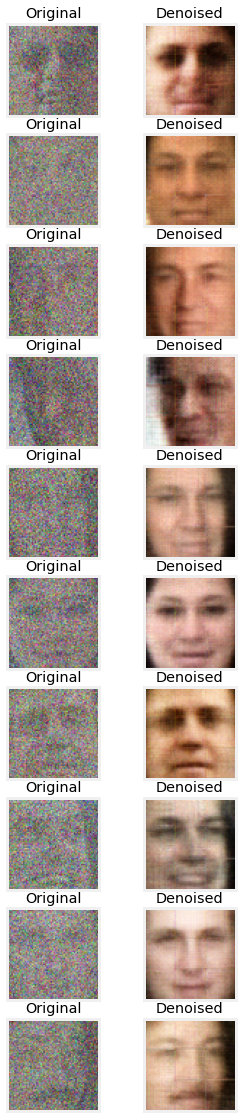

In [45]:
model.eval()

reconstructions = []
originals = []

with torch.no_grad():   
    for batch in val_loader:
        batch = batch.float().to(device)
        mu, logsigma, reconstructed = model(batch.view(-1, 3, 64, 64))
        reconstructed = reconstructed.view(-1, 64, 64, 3)
        result = reconstructed.detach().cpu().numpy()
        ground_truth = batch.detach().cpu().numpy()
        
        for i in range(len(batch)):
            reconstructions.append(result[i])
            originals.append(ground_truth[i])

fig, ax = plt.subplots(10, 2, figsize=(4, 20))

for i, (gt, res) in enumerate(zip(originals[:10], reconstructions[:10])):
    gt_norm = (gt - np.min(gt)) / (np.max(gt) - np.min(gt))
    res_norm =  (res - np.min(res)) / (np.max(res) - np.min(res))
    
    ax[i, 0].imshow(gt_norm)
    ax[i, 0].grid(False)
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_title("Original")
    ax[i, 1].imshow(res_norm)
    ax[i, 1].grid(False)
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title("Denoised")

plt.show()

## 5. Image Retrieval

Представим, что весь наш тренировочный датасет - это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Для этого можно с помощью VAE закодировать картинку в латентное представление и найти среди латентных представлений лиц нашей базы самые ближайшие.

План:

1. Получим латентные представления всех лиц тренировочного датасета
2. Обучим на них NearestNeighbors `(sklearn.neighbors.NearestNeighbors)`, например, с `n_estimators=50`
3. Возьмем картинку из тестового датасета и с помощью VAE получаем ее латентный вектор
4. С помощью обученного NearestNeighbors найдем ближайшие из латентных представлений тренировочной базы
5. После того, как найдем лица тренировочного датасета, которым соответствуют ближайшие латентные представления, выведем результат

In [65]:
data, attrs = fetch_dataset()
batch_size = 32
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_photos, batch_size)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size)

Обучим наш VAE:

In [66]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # a device used in training and testing
n_epochs = 50 # number of epochs
dim_code = 128 # shape of the latent-space

# a model, an optimizer & a loss function
model = VAE(channels=3, latent_shape=8, from_lat_kernel=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss

# lists to save losses
train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in tqdm(range(n_epochs)):
    model.train() # set the model to the train mode
    avg_train_loss = 0 # initiate loss training loss variable
    
    for X_batch in train_loader:
        # transfer data to the device
        X_batch = X_batch.float().to(device)
        optimizer.zero_grad() # set gradients parameters to zero
        mu, logsigma, reconstructed = model(X_batch.view(-1, 3, 64, 64)) # forward-pass
        reconstructed = reconstructed.view(-1, 64, 64, 3) # reshape the tensor to a proper output format
        loss = loss_fn(reconstructed, X_batch) # calculate the training loss
        loss.backward() # backward-pass
        optimizer.step()
        avg_train_loss += loss.detach().cpu().item() # add loss and transfer it to the cpu

    train_losses_per_epoch.append(avg_train_loss / len(train_loader)) # save the training loss

    model.eval() # set the model to the evaluation mode
    avg_val_loss = 0  # initiate loss evaluation loss variable
    
    with torch.no_grad():
        for X_batch in val_loader:
            # transfer data to the device
            X_batch = X_batch.float().to(device)
            mu, logsigma, reconstructed = model(X_batch.view(-1, 3, 64, 64)) # forward-pass
            reconstructed = reconstructed.view(-1, 64, 64, 3) # reshape the tensor to a proper output format
            loss = loss_fn(reconstructed, X_batch) # calculate the evaluation loss
            avg_val_loss += loss.detach().cpu().item() # add the loss and transfer it to the cpu

        val_losses_per_epoch.append(avg_val_loss / len(val_loader)) # save the evaluation loss

  0%|          | 0/50 [00:00<?, ?it/s]

Получим латентные представления картинок тренировочного датасета:

In [67]:
codes = []

# get latent representations of training images
with torch.no_grad():
    for batch in train_loader:
        batch = batch.float().to(device)
        mu, logsigma = model.encode(batch.view(-1, 3, 64, 64))

        for code in mu:
            codes.append(code.detach().cpu().numpy())

Напишем функцию для отправки запроса к базе и поиска похожих картинок с помощью NearestNeighbors:

In [89]:
from sklearn.neighbors import NearestNeighbors

def compute_similar_images(image, num_images, embedding, device="cuda"):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """
    
    image_tensor = torch.FloatTensor(image).to(device).view(-1, 3, 64, 64)
    
    # get a latent representation of the query image
    with torch.no_grad():
        mu, logsigma = model.encode(image_tensor)
        mu = mu.cpu().detach().numpy()
        logsigma = logsigma.cpu().detach().numpy()
        
    flattened_embedding = mu.reshape((mu.shape[0], -1))
    
    # find similar latent representations indices
    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = [i for i in indices[0]]
    
    return indices_list

Выполним запрос:

In [90]:
query_img = val_photos[2] # set the query image
similar_codes = compute_similar_images(query_img, 5, codes) # get similar latent representations id's

Визуализируем полученный результат:

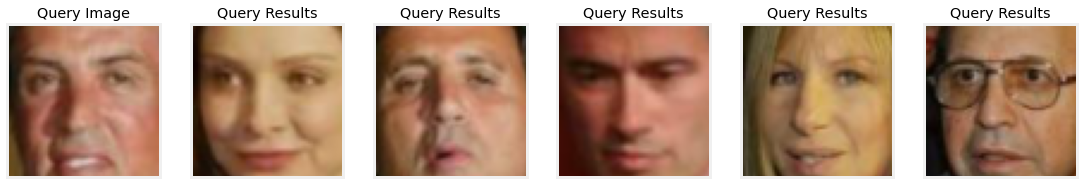

In [94]:
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 7, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(query_img)
ax.grid(False)
ax.set_title("Query Image")

for (i, img) in enumerate(train_photos[(similar_codes)], start=1):
    ax = fig.add_subplot(1, 7, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
    ax.grid(False)
    ax.set_title("Query Results")

plt.show()